In [155]:
!date

Wed Jul 17 14:51:19 EDT 2019


# Workforce Prediction

In this notebook, we tried to predict the inbound & outbound traffic from the warehouse, in order to help allocate workforce. Noted that the max capacity of the warehouse is 3500 orders/day as of July 2019, but our predictions are not limited by that. 

There are six types of warehouse activities: 
1. Outbound customer order
2. Outbound items transfer
3. Outbound purchase order return
4. Inbound customer return
5. Inbound items transfer
6. Inbound purchase order

We will focus on predicting the `Outbound Customer Order` here

### Imports and settings 

In [45]:
import pandas as pd
import numpy as np
import queries.utils as utils
from matplotlib import pyplot as plt


#### fbprophet 
import fbprophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

pd.plotting.register_matplotlib_converters() ## bugs.. fbprophet & matplotlib

### Import Data

In [14]:
#### Read the customer order data
dat = pd.read_csv('data/customer_orders.csv')
dat.tail()


,ds,y
1289,2019-07-13,1054
1290,2019-07-14,984
1291,2019-07-15,1193
1292,2019-07-16,1808
1293,2019-07-17,1016


In [ ]:
# #### Read the customer order data from gbq (update real time)
# from google.cloud import bigquery as bq
# client = bq.Client()
# with open( 'queries/customer_orders_query.sql') as f:
#     q_customer_orders = f.read()
# dat_realtime = client.query(q_customer_orders).to_dataframe()
# dat_realtime.tail()

In [15]:
#### Read the current prediction data from the forecast team
dat_curr_prediction = pd.read_csv('data/inven_curr_predictions.csv')
dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_OUT_Ord']]
dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_OUT_Ord':'out_cust_order_qty_curr'},inplace=True)
dat_curr_prediction.index = pd.to_datetime(dat_curr_prediction['ds'])
dat_curr_prediction.drop(["ds"],axis=1,inplace=True)
dat_curr_prediction.tail()

,out_cust_order_qty_curr
ds,
2019-12-24,1181.40
2019-12-25,1251.59
2019-12-26,1052.94
2019-12-27,1092.03
2019-12-28,1090.09


In [13]:
#### Read holiday/markdown info
holidays = pd.read_csv('data/mo_holidays.csv')
holidays.tail()

,ds,holiday,lower_window,upper_window,flag_data
52,2017-12-17,Extra % Off Promo,0,3,NaN
53,2019-01-17,Extra % Off Promo,0,4,NaN
54,2018-12-19,Extra % Off Promo,0,4,NaN
55,2018-08-01,Extra % Off Promo,0,5,NaN
56,2019-07-23,Extra % Off Promo,0,7,NaN


## FB Prophet Model

In [27]:
fbprophet.__version__

Prophet = fbprophet.Prophet

### Data Preparation

In [22]:
# Parameters Settings

split_date = '2019-05-19'  # Setting the train test cutoff date
forward_days = 200  # set up how


In [23]:
dat_train = dat.loc[dat.ds<split_date , :]
dat_test = dat.loc[dat.ds>=split_date , :]

In [25]:
dat_all = pd.concat([dat_train,dat_test])
dat_all.shape

(1294, 2)

### Baseline Model With Holiday / Regressors to Capture the Promotion Event

#### Model set up

In [28]:
m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )

# ### Add extra regressors
# # dat_train['markdown'] =  ??
# # m.add_regressor('markdown', prior_scale = 10) 


In [29]:
m.fit(dat_train)
m_full.fit(dat_all)

### Test

In [30]:
# predict forward_days 
future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')
forecast = m.predict(future)
forecast.loc[forecast.ds>=split_date,:].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Employee Sale,Employee Sale_lower,Employee Sale_upper,Extra % Off Promo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1234,2019-05-19,864.919832,1057.465982,1444.764674,864.919832,864.919832,0.0,0.0,0.0,0.0,...,-0.309451,-0.309451,-0.309451,0.452912,0.452912,0.452912,0.0,0.0,0.0,1237.521128
1235,2019-05-20,866.732369,1226.173133,1624.088153,866.732369,866.732369,0.0,0.0,0.0,0.0,...,-0.156723,-0.156723,-0.156723,0.454066,0.454066,0.454066,0.0,0.0,0.0,1416.812555
1236,2019-05-21,868.544907,1446.975416,1854.865550,868.544907,868.544907,0.0,0.0,0.0,0.0,...,0.086708,0.086708,0.086708,0.452620,0.452620,0.452620,0.0,0.0,0.0,1655.466469
1237,2019-05-22,870.357444,2250.427828,2665.742124,870.357444,870.357444,0.0,0.0,0.0,0.0,...,0.207349,0.207349,0.207349,0.448767,0.448767,0.448767,0.0,0.0,0.0,2458.863269
1238,2019-05-23,872.169982,1650.607356,2079.493333,872.169982,872.169982,0.0,0.0,0.0,0.0,...,0.134687,0.134687,0.134687,0.442746,0.442746,0.442746,0.0,0.0,0.0,1855.768108


### Validation

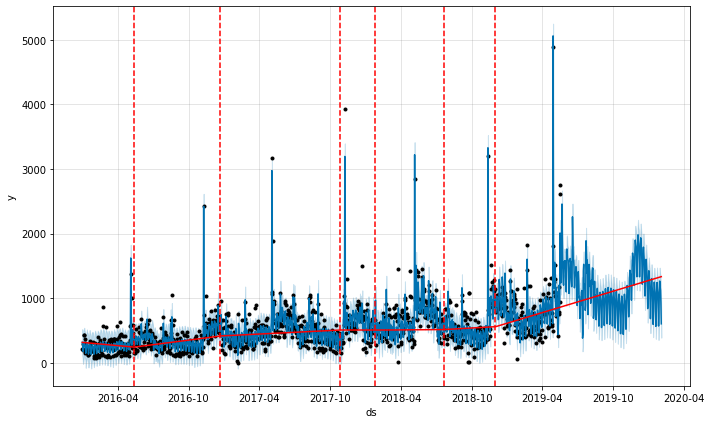

In [31]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

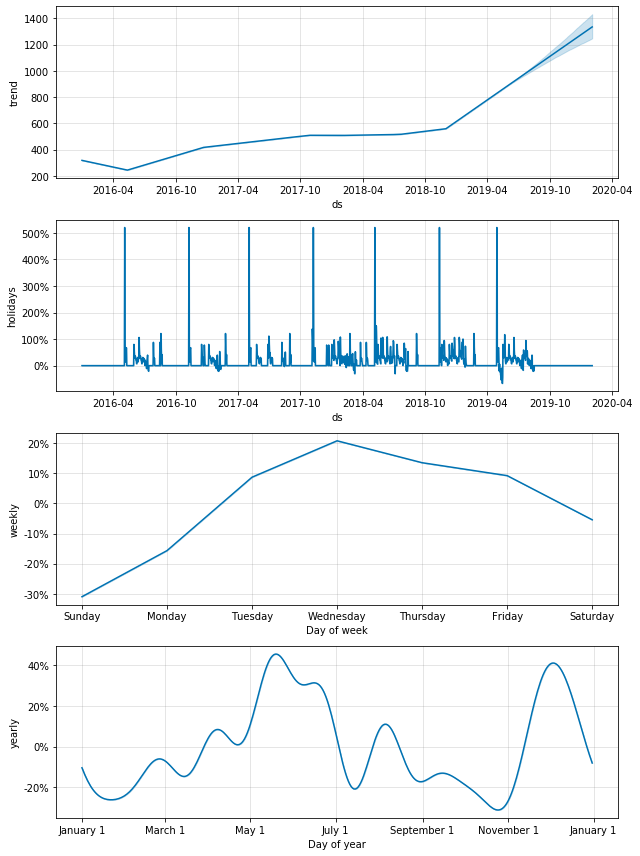

In [32]:
f = m.plot_components(forecast)

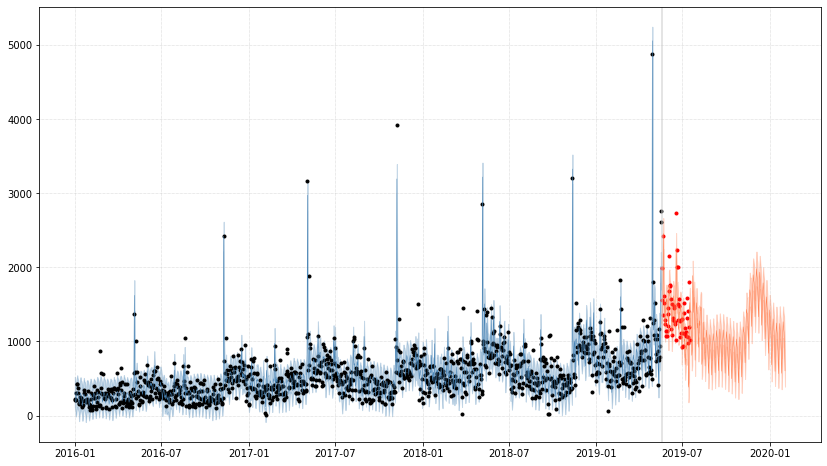

In [46]:
verif = utils.make_verif(forecast, dat_train, dat_test)
f = utils.plot_verif(verif,date=split_date)

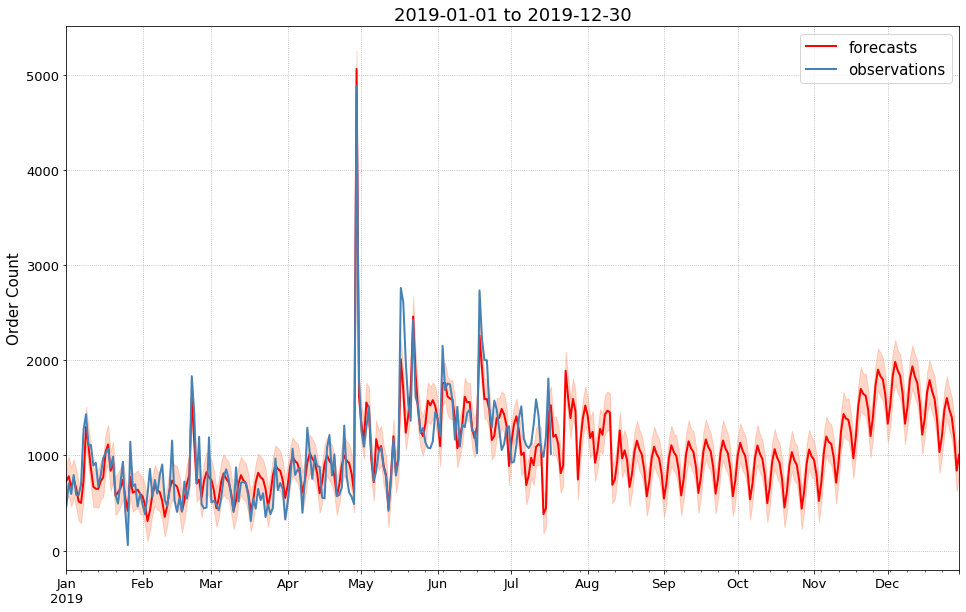

In [47]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(verif, '2019-01-01', '2019-12-30', ax=ax)

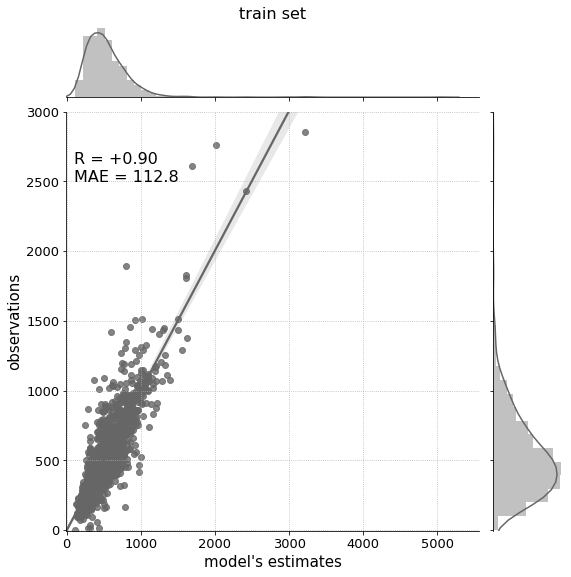

In [48]:
utils.plot_joint_plot(verif.loc[verif.index<split_date,:], title='train set', fname=None)

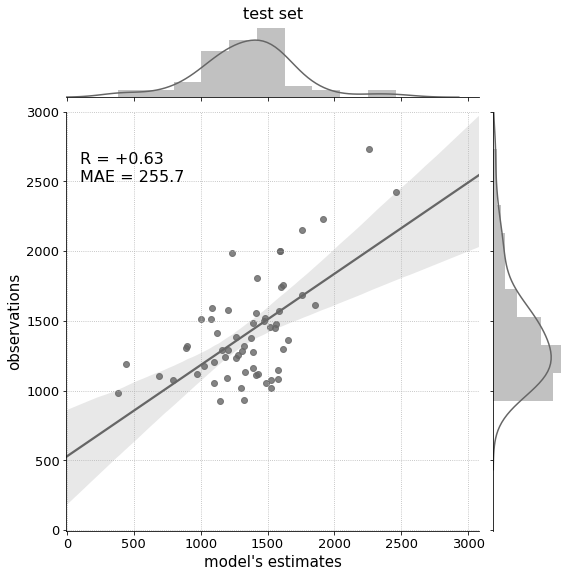

In [49]:
utils.plot_joint_plot(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Only validate data up until 07/04/2019

In [50]:
m_full.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'VIP Sale',
  'Markdowns',
  'Tiered Promo',
  'Employee Sale',
  'Full Price Promo',
  'Extra % Off Promo',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [51]:
# This is from Prophet
df_cv = cross_validation(m_full, initial='730 days', period='30 days', horizon = '14 days')

INFO:fbprophet:Making 19 forecasts with cutoffs between 2018-01-09 00:00:00 and 2019-07-03 00:00:00


In [72]:
df_cv_two_week = cross_validation(m_full, initial='1210 days', period='1 days', horizon = '14 days')

INFO:fbprophet:Making 70 forecasts with cutoffs between 2019-04-25 00:00:00 and 2019-07-03 00:00:00


In [52]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,2 days,45705.859692,213.789288,167.231192,0.234683,0.631579
1,3 days,53148.808608,230.540254,189.406825,0.288868,0.531111
2,4 days,64160.038033,253.298318,201.044483,0.320155,0.520000
3,5 days,65974.100657,256.854240,209.827039,0.271805,0.566316
4,6 days,104025.991847,322.530606,244.484875,0.271487,0.538947


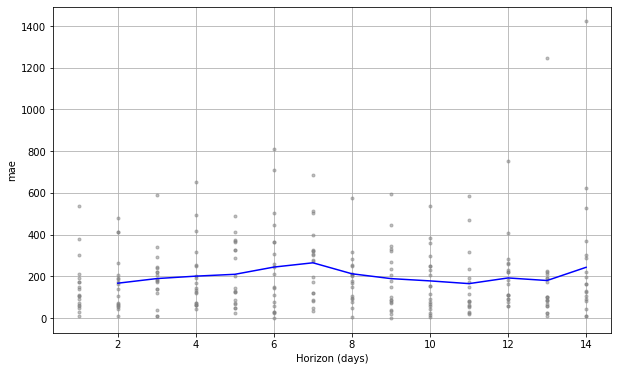

In [66]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

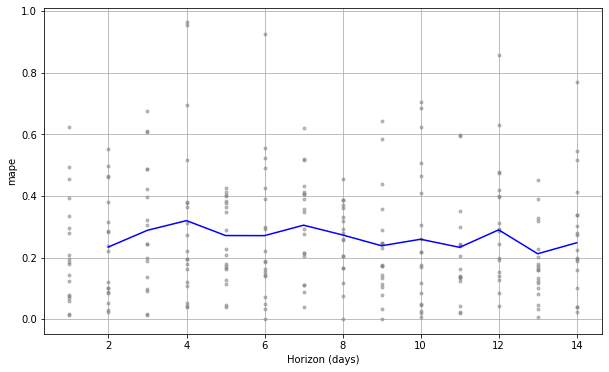

In [67]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

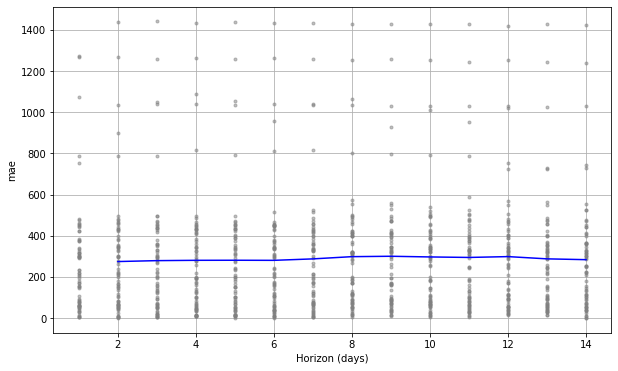

In [143]:
fig = plot_cross_validation_metric(df_cv_two_week, metric='mae')

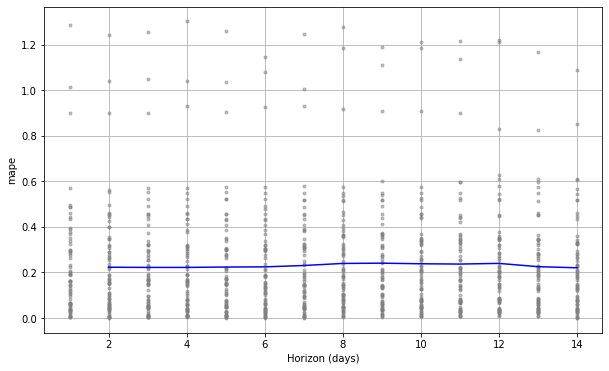

In [144]:
fig = plot_cross_validation_metric(df_cv_two_week, metric='mape')

In [138]:
df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

In [152]:
verif_comp = pd.concat([dat_curr_prediction, verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','out_cust_order_qty_curr'])
verif_comp = verif_comp.loc[verif_comp['y'].notnull() ,:]
verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'out_cust_order_qty_curr':'Current Excel Model'} ,inplace=True)

verif_comp = verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

verif_comp.head()

,yhat_lower,yhat_upper,Prophet Model up until 2019-05-19,Observations,Current Excel Model,Prophet Model Two Weeks Ahead,yhat_lower_2w,yhat_upper_2w,y,cutoff,horizon
ds,,,,,,,,,,,
2019-05-19,1057.465982,1444.764674,1237.521128,1990.0,2144.79,960.010106,772.645829,1168.949807,1990,2019-05-05,14 days
2019-05-20,1226.173133,1624.088153,1416.812555,1554.0,1884.79,1140.187453,948.235534,1324.495032,1554,2019-05-06,14 days
2019-05-21,1446.975416,1854.865550,1655.466469,1363.0,2088.79,1351.249100,1149.807945,1551.003961,1363,2019-05-07,14 days
2019-05-22,2250.427828,2665.742124,2458.863269,2423.0,1868.79,2092.054431,1896.883497,2284.376829,2423,2019-05-08,14 days
2019-05-23,1650.607356,2079.493333,1855.768108,1612.0,1696.51,1547.426607,1337.286788,1736.202824,1612,2019-05-09,14 days


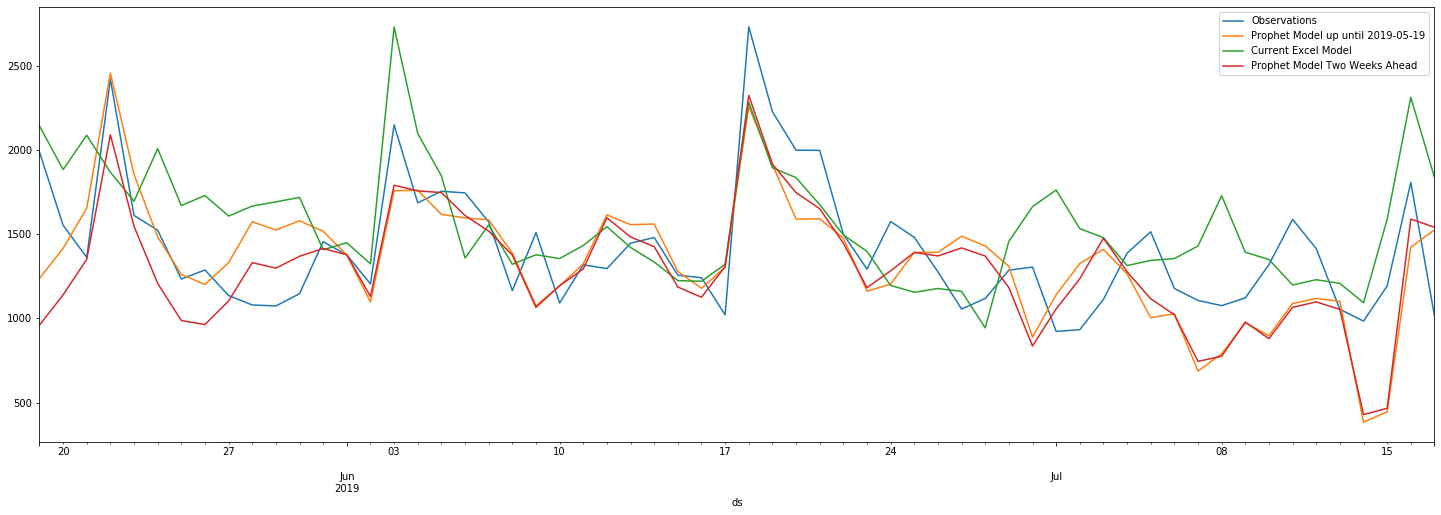

In [153]:
_, ax = plt.subplots(figsize=(25,8))
verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


In [154]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(verif_comp['Current Excel Model'] - verif_comp['Observations'])/verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp[f'Prophet Model up until {split_date}'] - verif_comp['Observations'])/verif_comp['Observations'])))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(verif_comp['Prophet Model Two Weeks Ahead'] - verif_comp['Observations'])/verif_comp['Observations'])))



MAPE of the Current Model 0.2266742076173006
MAPE of the Prophet Model Up Until 2019-05-19  0.19282907542212696
MAPE of the Prophet Model Two Weeks Prediction  0.1794466915878395
